## **Fine-tuning LayoutLMv3 using the FUNSD dataset**

This notebook is my attempt at fine-tuning the LayoutLMv3 model using the FUNSD dataset for information extraction. The model is presented in the paper "LayoutLM: Pre-training of Text and Layout for Document Image Understanding" by Yiheng Xu, Minghao Li, Lei Cui, Shaohan Huang, Furu Wei and Ming Zhou

# Notebook Setup

In [ ]:
!pip install transformers==4.28.0
! sudo apt install tesseract-ocr
! pip install -q pytesseract --progress-bar off
!pip install -qqq easyocr==1.6.2 --progress-bar off
! pip install -q datasets seqeval --progress-bar off
! pip install --upgrade accelerate
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-oc

In [ ]:
import numpy as np
import pandas as pd
import os
import json
import torch

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import cv2
import glob
from google.colab import drive
from PIL import Image, ImageDraw, ImageFont

from difflib import SequenceMatcher


In [ ]:
import pytesseract
import easyocr
from datasets import Dataset , load_metric,Features, Sequence, ClassLabel, Value, Array2D, Array3D
from tqdm.notebook import tqdm

import evaluate
import numpy as np

from accelerate.state import PartialState
from transformers import  LayoutLMv3ForTokenClassification,  TrainingArguments, Trainer ,AutoProcessor,AdamW
from transformers.data.data_collator import default_data_collator


In [ ]:
#drive.mount('/content/drive')

# Load Data

---




In [ ]:
df= pd.read_excel('/content/drive/MyDrive/PFE/docs content.xlsx')
df = df[df['label']=='Formulaire'].reset_index(drop = True)
df

,Unnamed: 0,document,label,names
0,0,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,82092117.png
1,1,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,82200067_0069.png
2,2,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,82250337_0338.png
3,3,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,82251504.png
4,4,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,82252956_2958.png
...,...,...,...,...
194,194,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,93213298.png
195,195,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,93329540.png
196,196,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,93351929_93351931.png
197,197,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,93380187.png


## Extract the forms from the merged data

In [ ]:
formannos = []
for i in range(len(df)):
  formannos.append('/content/drive/MyDrive/PFE/data/dataset/testing_data/annotations/'+ os.path.splitext(os.path.basename(df['document'][i]))[0]+'.json')

In [ ]:
df['ocr'] =formannos
df.drop({'Unnamed: 0','names'},axis=1,inplace=True)
df

,document,label,ocr
0,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,/content/drive/MyDrive/PFE/data/dataset/testin...
1,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,/content/drive/MyDrive/PFE/data/dataset/testin...
2,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,/content/drive/MyDrive/PFE/data/dataset/testin...
3,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,/content/drive/MyDrive/PFE/data/dataset/testin...
4,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,/content/drive/MyDrive/PFE/data/dataset/testin...
...,...,...,...
194,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,/content/drive/MyDrive/PFE/data/dataset/testin...
195,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,/content/drive/MyDrive/PFE/data/dataset/testin...
196,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,/content/drive/MyDrive/PFE/data/dataset/testin...
197,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,/content/drive/MyDrive/PFE/data/dataset/testin...


In [ ]:
df[df['ocr']=='/content/drive/MyDrive/PFE/data/dataset/testing_data/annotations/0000971160.json']

,document,label,ocr
50,/content/drive/MyDrive/PFE/data/dataset/testin...,Formulaire,/content/drive/MyDrive/PFE/data/dataset/testin...


In [ ]:
df['ocr'][0]

'/content/drive/MyDrive/PFE/data/dataset/testing_data/annotations/82092117.json'

## Prepare the data

---



In [ ]:
def form_content(path_json):
  text_list = []
  boxes = []
  label = []
  with open(path_json, 'r') as f:
    data = json.load(f)
    for i in range(len(data['form'])):
      # other --> O
      if data['form'][i]['label'] == 'other':
        text_list.append(data['form'][i]['text'])
        boxes.append(data['form'][i]['box'])
        label.append('O')

      else :
          # word
          if len(data['form'][i]['words']) == 1 :
            text_list.append(data['form'][i]['text'])
            boxes.append(data['form'][i]['box'])
            label.append('B-' + data['form'][i]['label'].upper())

          else :
            # sentence
            # beginning
            text_list.append(data['form'][i]['words'][0]['text'])
            boxes.append(data['form'][i]['box'])
            label.append('B-' + data['form'][i]['label'].upper())
            # inside
            for j in range(1,len(data['form'][i]['words'])):
              text_list.append(data['form'][i]['words'][j]['text'])
              boxes.append(data['form'][i]['box'])
              label.append('I-' + data['form'][i]['label'].upper())

  return text_list,boxes,label

In [ ]:
text_list = []
boxes = []
word_labels = []

 # ner_tags de tokens :
label_list=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']
id2label = {0: 'O', 1: 'B-HEADER', 2: 'I-HEADER', 3: 'B-QUESTION', 4: 'I-QUESTION', 5: 'B-ANSWER', 6: 'I-ANSWER'}
label2id = {'O': 0, 'B-HEADER': 1, 'I-HEADER': 2, 'B-QUESTION': 3, 'I-QUESTION': 4, 'B-ANSWER': 5, 'I-ANSWER': 6}
for i in range(len(df)):

  text_list.append(form_content(df['ocr'][i])[0])
  boxes.append(form_content(df['ocr'][i])[1])
  word_labels.append([label2id[t] for t in form_content(df['ocr'][i])[2]])

In [ ]:
# CHECK values of labels
t = []
for i in range(len(word_labels)):
  for j in range(len(word_labels[i])):
    #  t.append(i)
      t.append(word_labels[i][j])
set(t)

{0, 1, 2, 3, 4, 5, 6}

In [ ]:
# check the type of the words

t = []
for i in range(len(text_list)):
  for j in range(len(text_list[i])):
    #  t.append(i)
      t.append(type(text_list[i][j]))
set(t)

{str}

In [ ]:
# check the type of the boxes

t = []
for i in range(len(boxes)):
  for j in range(len(boxes[i])):
    for z in range(len(boxes[i][j])):
    #  t.append(i)
      t.append(type(boxes[i][j][z]))
set(t)

{int}

In [ ]:
#features: ['tokens', 'bboxes', 'label', 'document'],
df['tokens']=text_list
df['bboxes']=boxes
df['label']=word_labels
df.drop('ocr',axis=1,inplace=True)

In [ ]:
df_copy=df.copy()



## Plot the distribution of entities in each document

In [ ]:
df_t=df.iloc[0:4]
df_t

,document,label,tokens,bboxes
0,/content/drive/MyDrive/PFE/data/dataset/testin...,"[0, 3, 3, 5, 3, 3, 0, 5, 6, 6, 0, 0, 1, 2, 2, ...","[, TO:, DATE:, 3, Fax:, NOTE:, 82092117, 614, ...","[[61, 127, 143, 211], [102, 345, 129, 359], [1..."
1,/content/drive/MyDrive/PFE/data/dataset/testin...,"[3, 3, 5, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, ...","[TO:, FROM:, x, SUBJECT:, , , DIVISION:, DIVIS...","[[75, 140, 93, 153], [75, 168, 109, 181], [633..."
2,/content/drive/MyDrive/PFE/data/dataset/testin...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 0, 1, 2, 2, ...","[TO:, FROM:, DATE:, MANUFACTURER:, BRAND:, Oct...","[[94, 200, 114, 214], [92, 219, 128, 232], [95..."
3,/content/drive/MyDrive/PFE/data/dataset/testin...,"[5, 3, 3, 3, 3, 3, 5, 0, 3, 3, 0, 0, 0, 0, 0, ...","[17, cc:, :, From:, Area:, Region:, 5, X, Chai...","[[362, 304, 379, 315], [446, 257, 461, 267], [..."


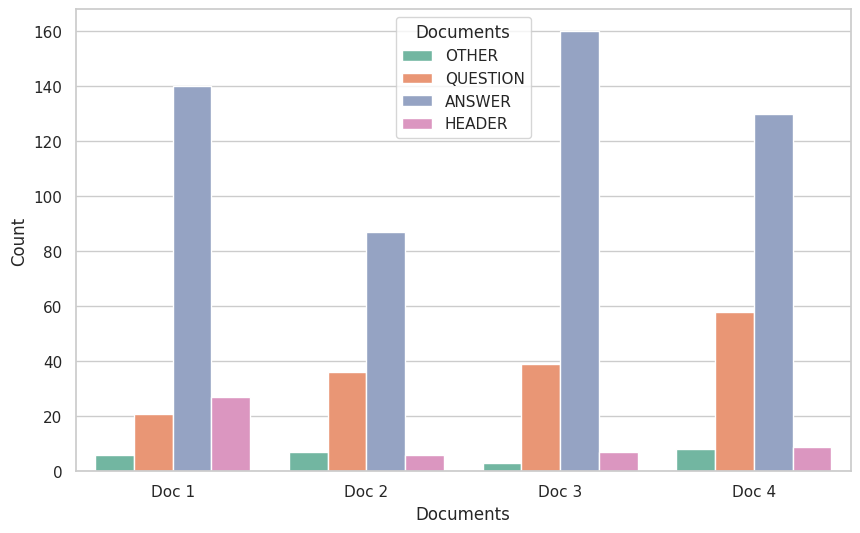

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Your list of documents
documents = df_t['label']

# Flatten the list of documents and create a corresponding list of document labels
flattened_categories = ['Doc {}'.format(i+1) for i in range(len(documents)) for _ in range(len(documents[i]))]
doc_labels = [category for doc in documents for category in doc]

# Create a Pandas DataFrame with the categories and document labels
df = pd.DataFrame({'Category': flattened_categories, 'Document': doc_labels})

df['Document'] = df['Document'].replace({0: 'OTHER', 1: 'HEADER', 2: 'HEADER', 3: 'QUESTION', 4: 'QUESTION', 5: 'ANSWER', 6: 'ANSWER'})

# Create a countplot
sns.set(style="whitegrid")  # Optional: Set the plot style
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
sns.countplot(data=df, x='Category', hue='Document',palette = 'Set2')

# Add labels and title
plt.xlabel('Documents')
plt.ylabel('Count')
plt.legend(title='Documents')

# Show the plot
plt.show()


##Test preparation

In [ ]:
image = Image.open(df['document'][0]).convert("RGB")
image
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label
label2color = {'header':'blue', 'question':'green', 'answer':'orange', 'other':'violet'}

for word, box, label in zip(df['tokens'][0],df['bboxes'][0],
                          df['label'][0]):
  actual_label = iob_to_label(id2label[label]).lower()
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image
image.save("modified_image.jpg")

#Processing

In [ ]:
#split data
train,test,  = train_test_split(df, test_size=0.25,random_state=42)

train

,document,label,tokens,bboxes
56,/content/drive/MyDrive/PFE/data/dataset/testin...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, ...","[FAX:, DATE:, FROM:, CHARGEBACK:, RECIPIENT, C...","[[96, 177, 118, 192], [75, 337, 116, 351], [75..."
5,/content/drive/MyDrive/PFE/data/dataset/testin...,"[0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 0, 0, 0, ...","[82253058, LORILLARD, TO:, FROM:, DATE:, AUG, ...","[[570, 901, 672, 928], [384, 63, 445, 76], [94..."
122,/content/drive/MyDrive/PFE/data/dataset/testin...,"[3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 5, 0, 5, ...","[VENDOR, TERMS, VIA, Attn:, NET, DATE, UNIT, P...","[[21, 244, 67, 254], [50, 289, 86, 300], [373,..."
113,/content/drive/MyDrive/PFE/data/dataset/testin...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, ...","[COMPOUND, SOURCE:, INVESTIGATOR(S), SIGNATURE...","[[74, 119, 124, 137], [74, 154, 115, 169], [74..."
93,/content/drive/MyDrive/PFE/data/dataset/testin...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, ...","[Brand(s), Company, DATE, SIGNATURE, NAME, Ori...","[[448, 216, 504, 234], [84, 214, 143, 232], [6..."
...,...,...,...,...
106,/content/drive/MyDrive/PFE/data/dataset/testin...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[Telephone:, TELEPHONE, AME, AFFILLATION, DDRE...","[[503, 63, 560, 81], [444, 134, 521, 154], [14..."
14,/content/drive/MyDrive/PFE/data/dataset/testin...,"[3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 0, 0, 0, 0, 1, ...","[DATE:, COMPANY:, PHONE:, FROM:, PHONE:, MESSA...","[[91, 223, 127, 238], [89, 313, 153, 330], [91..."
92,/content/drive/MyDrive/PFE/data/dataset/testin...,"[3, 3, 3, 3, 1, 2, 2, 3, 4, 3, 4, 4, 4, 4, 4, ...","[Supplier:, APPROVED, Tester, Manager, TEST, A...","[[149, 170, 217, 181], [196, 352, 259, 363], [..."
179,/content/drive/MyDrive/PFE/data/dataset/testin...,"[0, 1, 1, 1, 3, 3, 3, 5, 3, 3, 3, 0, 0, 0, 0, ...","[1, COMPANY, TOBACCO, Lorillard, DATE:, NAME:,...","[[196, 38, 220, 55], [189, 163, 252, 178], [13..."


In [ ]:
# read df as Datasets object
dataset = Dataset.from_pandas(train).remove_columns(["__index_level_0__"])
test_dataset = Dataset.from_pandas(test).remove_columns(["__index_level_0__"])

dataset , test_dataset

(Dataset({
     features: ['document', 'label', 'tokens', 'bboxes'],
     num_rows: 149
 }),
 Dataset({
     features: ['document', 'label', 'tokens', 'bboxes'],
     num_rows: 50
 }))

In [ ]:
def normalize_boxes(bbox, image):
    w, h = image.size
     # Normalize bounding box coordinates
    norm_bbox = [bbox[0]/w, bbox[1]/h, bbox[2]/w, bbox[3]/h]
     # rane [0 , 1000]
    return [
         int(1000 * norm_bbox[0]),
         int(1000 * norm_bbox[1]),
         int(1000 * norm_bbox[2]),
         int(1000 * norm_bbox[3])
     ]

In [ ]:
# Load and preprocess the input documents
def load_data(examples) :
  mimages = []
  for doc_path in examples['document']:
      img =  Image.open(doc_path).convert("RGB")
      mimages.append(img)
  return mimages

## LayoutLMv3Processor

In [ ]:
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [ ]:
def preprocess_data(examples):
  normalized_boxes=[]
  # Load and preprocess the input documents
  images = load_data(examples)
  boxes = examples['bboxes']
  for i in range(len(images)):
      normalized_boxes.append([normalize_boxes(box, images[i]) for box in boxes[i]])

  text_list = examples['tokens']
  word_labels = examples['label']

  #to pad the sequences to the same length (padding=True)
  #and truncated if they exceed the maximum sequence length  (truncation=True)
  encoded_inputs = processor(images,
                             text_list,
                             boxes=normalized_boxes,
                             word_labels=word_labels,
                             truncation=True, padding="max_length")

  # add labels
  return encoded_inputs

## Mapping

In [ ]:
features = Features(
{   'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=label_list))
 })

# batch_size = : need to set a smaller batch_size to avoid running out of memory during training.
encoded_dataset= dataset.map(preprocess_data,
                              remove_columns=dataset.column_names,
                              features=features,
                              batched=True, batch_size=2
                             )

encoded_val = test_dataset.map(preprocess_data,
                              remove_columns=dataset.column_names,
                              features=features,
                              batched=True, batch_size=2
                             )

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
encoded_dataset.features

{'pixel_values': Array3D(shape=(3, 224, 224), dtype='float32', id=None),
 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'bbox': Array2D(shape=(512, 4), dtype='int64', id=None),
 'labels': Sequence(feature=ClassLabel(names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None)}

In [ ]:
#to return PyTorch tensors (return_tensors="pt") as the LayoutLM implementation in the Transformers library is in PyTorch.
encoded_dataset.set_format(type="torch")
#encoded_val.set_format(type="torch")

# Modeling

## Define metrics


In [ ]:
import evaluate
metric = evaluate.load("seqeval")

In [ ]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Define the model
## **✳ *token Classification* ✳**



## Training

In [ ]:
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         num_labels=len(label_list),
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(output_dir="testFUNSD",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [ ]:
# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset,
    eval_dataset=encoded_val,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.542797,0.753610,0.819241,0.785056,0.844886
200,No log,0.384693,0.803332,0.878987,0.839458,0.883304
300,No log,0.396234,0.836725,0.895190,0.864971,0.887626
400,No log,0.359868,0.845097,0.903291,0.873226,0.903474
500,0.409600,0.421836,0.848600,0.905316,0.876041,0.894349
600,0.409600,0.363262,0.835081,0.887089,0.860300,0.903954
700,0.409600,0.413949,0.857074,0.901772,0.878855,0.901393
800,0.409600,0.441704,0.857349,0.900759,0.878519,0.902833
900,0.409600,0.448827,0.856591,0.898228,0.876915,0.903794
1000,0.097600,0.452064,0.856936,0.900759,0.878302,0.904114


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.2535790824890137, metrics={'train_runtime': 540.8935, 'train_samples_per_second': 3.698, 'train_steps_per_second': 1.849, 'total_flos': 523783817001984.0, 'train_loss': 0.2535790824890137, 'epoch': 13.33})

# Evaluate

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.4520642161369324,
 'eval_precision': 0.8569364161849711,
 'eval_recall': 0.900759493670886,
 'eval_f1': 0.8783016539126142,
 'eval_accuracy': 0.9041139747078598,
 'eval_runtime': 5.9408,
 'eval_samples_per_second': 8.416,
 'eval_steps_per_second': 4.208,
 'epoch': 13.33}